In [9]:
import os
import gc
import random
import itertools
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
import tokenizers
import transformers
from transformers import AutoTokenizer, EncoderDecoderModel, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
import datasets
from datasets import load_dataset, load_metric
import sentencepiece
import argparse
from datasets.utils.logging import disable_progress_bar
from rdkit import Chem
import rdkit
disable_progress_bar()

class CFG:
    model = 't5'
    dataset_path = 'multiinput_prediction_output.csv'
    model_name_or_path = 'sagawa/ReactionT5-product-prediction'
    num_beams = 5
    num_return_sequences = 5
    debug = True
    seed = 42
    

device = 'cpu'

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(seed=CFG.seed)  
    

# dataset = pd.read_csv(CFG.dataset_path)

tokenizer = AutoTokenizer.from_pretrained(CFG.model_name_or_path, return_tensors='pt')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [24]:
from rdkit import Chem
def canonicalize(mol):
    mol = Chem.MolToSmiles(Chem.MolFromSmiles(mol),True)
    return mol
def canonicalize2(mol):
    try:
        return canonicalize(mol)
    except:
        return None
def remove_space(row):
    for i in range(5):
        row[f'{i}th'] = row[f'{i}th'].replace(' ', '')
#     row['valid compound'] = row['valid compound'].replace(' ', '')
    return row


In [21]:
df = pd.read_csv('/home/acf15718oa/ReactionT5_neword/multitask_no_pretraining/output.csv')
seed_everything(seed=CFG.seed)  
# df['target'] = pd.read_csv('sampled.csv')['PRODUCT']
df

input  \
0      TASK_FORWARDREACTANT:N#Cc1ccsc1N.O=[N+]([O-])c...   
1      TASK_FORWARDREACTANT:COC(=O)Cc1cn(C)c2cc(O)ccc...   
2      TASK_FORWARDREACTANT:Cl.NC1CCN(CC2Cn3c(=O)ccc4...   
3      TASK_FORWARDREACTANT:C=C(C)C(=O)Cl.CC(C)=C1C(=...   
4      TASK_FORWARDREACTANT:O=Cc1cncc(Cl)c1COC1CCCCO1...   
...                                                  ...   
45897  TASK_YIELDREACTANT:Brc1ccccn1.Cc1ccc(N)cc1REAG...   
45898  TASK_YIELDREACTANT:Ic1ccccn1.Cc1ccc(N)cc1REAGE...   
45899  TASK_YIELDREACTANT:Clc1cccnc1.Cc1ccc(N)cc1REAG...   
45900  TASK_YIELDREACTANT:Brc1cccnc1.Cc1ccc(N)cc1REAG...   
45901  TASK_YIELDREACTANT:Ic1cccnc1.Cc1ccc(N)cc1REAGE...   

                                                     0th  \
0                  N#Cc1ccsc1Nc1cc(F)c(F)cc1[N+](=O)[O-]   
1      COC(=O)Cc1cn(C)c2cc(OCC(C)c3cn(-c4ccc(C(F)(F)F...   
2      O=c1ccc2ncc(F)c3c2n1CC3CN1CCC(NCc2cc3c(cn2)OCS...   
3      C=C(C)C(=O)Oc1ccc(N2C(=O)C(=C(C)C)C(=C(C)c3cc(...   
4                               OCc1cncc(Cl)c1COC1CCCCO1   
...                                                  ...   
45897                                                80%   
45898                                                80%   
45899                                                 0%   
45900                                                80%   
45901                                                80%   

                                                     1th  \
0                  N#Cc1ccsc1Nc1cc(F)c([N+](=O)[O-])cc1F   
1      COCC(C)c1cn(C)c2cc(OCC(C)c3cn(-c4ccc(C(F)(F)F)...   
2      O=c1ccc2ncc(F)c3c2n1CC3CN1CCC2NC(c3cc4c(cn3)OC...   
3      C=C(C)C(=O)Oc1ccc(N2C(=O)C(=C(C)C)C(C(C)=C3C(=...   
4                                      O=Cc1cncc(Cl)c1CO   
...                                                  ...   
45897                                                90%   
45898                                                90%   
45899                                                10%   
45900                                                70%   
45901                                                90%   

                                                     2th  \
0                 N#Cc1ccsc1Nc1cc(Cl)c(F)cc1[N+](=O)[O-]   
1      COCCOC(=O)Cc1cn(C)c2cc(OCC(C)c3cn(-c4ccc(C(F)(...   
2      O=c1ccc2ncc(F)c3c2n1CC3CN1CCC2NC(c3cc4c(cn3)OC...   
3      C=C(C)C(=O)Oc1ccc(N2C(=O)C(=C(C)C)C(C(C)=Cc3cc...   
4                              O=Cc1cncc(Cl)c1COC1CCCCO1   
...                                                  ...   
45897                                                70%   
45898                                                70%   
45899                                                20%   
45900                                                90%   
45901                                                70%   

                                                     3th  \
0                             N#Cc1ccsc1Nc1cc(F)c(F)cc1F   
1      COC(=O)Cc1cn(C)c2cc(OCC(C)c3cn(-c5ccc(C(F)(F)F...   
2      O=c1ccc2ncc(F)n3c2n1CC3CN1CCC(NCc2cc3c(cn2)OCS...   
3      C=C(C)C(=O)Oc1ccc(N2C(=O)C(=C(C)C)C(=C(C)C)C2=...   
4                              OOCc1cncc(Cl)c1COC1CCCCO1   
...                                                  ...   
45897                                                60%   
45898                                                60%   
45899                                                30%   
45900                                                60%   
45901                                                60%   

                                                     4th     0th score  \
0                             N#Cc1ccsc1Nc1cc(O)c(F)cc1F -1.578716e-07   
1      COC(=O)Cc1cn(C)c2cc(OCC(C)c3cc(-c4ccc(C(F)(F)F... -4.044596e-08   
2      O=c1ccc2ncc(F)c3c(c2n1CC1CCN(C2Cc4cc5c(cn4)OCS... -1.175710e-06   
3      C=C(C)C(=O)Oc1ccc(N2C(=O)C(=C(C)C)C(C(C)=C3C(=... -5.774194e-08   
4                                Cc1cncc(Cl)c1COC1CCCCO1 -6.185979e-04   
..

In [22]:
df = df[df["input"].str.startswith("TASK_FORWARD")].reset_index(drop=True)

df['target'] = pd.read_csv("/home/acf15718oa/ReactionT5_neword/data/USPTO_MIT/MIT_separated/test.csv")["PRODUCT"].to_list() 
df = df.apply(remove_space, axis=1)

# + pd.read_csv("/home/acf15718oa/ReactionT5_neword/data/USPTO_50k/test.csv")["REACTANT"].to_list() +
# target_yield = pd.read_csv("/home/acf15718oa/ReactionT5_neword/data/C_N_yield/MFF_Test1/test.csv")["YIELD"].to_list()

In [25]:
top_k_invalidity = 5

top1, top2, top3, top5 = [], [], [], []
invalidity = []

for idx, row in df.iterrows():
    target = canonicalize(row['target'])
    if canonicalize2(row['0th']) == target:
        top1.append(1)
        top2.append(1)
        top3.append(1)
        top5.append(1)
    elif canonicalize2(row['1th']) == target:
        top1.append(0)
        top2.append(1)
        top3.append(1)
        top5.append(1)
    elif canonicalize2(row['2th']) == target:
        top1.append(0)
        top2.append(0)
        top3.append(1)
        top5.append(1)
    elif canonicalize2(row['3th']) == target:
        top1.append(0)
        top2.append(0)
        top3.append(0)
        top5.append(1)
    elif canonicalize2(row['4th']) == target:
        top1.append(0)
        top2.append(0)
        top3.append(0)
        top5.append(1)
    else:
        top1.append(0)
        top2.append(0)
        top3.append(0)
        top5.append(0)

        
    input_compound = row['input']
    output = [row[f'{i}th'] for i in range(top_k_invalidity)]
    inval_score = 0
    for ith, out in enumerate(output):
        mol = Chem.MolFromSmiles(out.rstrip('.'))
        if type(mol) != rdkit.Chem.rdchem.Mol:
            inval_score += 1
    invalidity.append(inval_score)
df['top1_accuracy'] = top1
df['top2_accuracy'] = top2
df['top3_accuracy'] = top3
df['top5_accuracy'] = top5
df['invalidity'] = invalidity

[15:15:10] SMILES Parse Error: unclosed ring for input: 'O=c1ccc2ncc(F)c3c2n1CC3CN1CCC2NC(c3cc4c(cn3)OCS4)C(O)C1'
[15:15:10] SMILES Parse Error: unclosed ring for input: 'O=c1ccc2ncc(F)c3c2n1CC3CN1CCC2NC(c3cc4c(cn3)OCS4)C(O)C1O'
[15:15:10] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 10
[15:15:10] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 9 10 11
[15:15:10] Can't kekulize mol.  Unkekulized atoms: 31
[15:15:10] Explicit valence for atom # 16 C, 6, is greater than permitted
[15:15:10] SMILES Parse Error: extra close parentheses while parsing: Fc1cc(-c2nc(CN3CCCCC3)co3)co2)ccc1OCCCN1CCCCC1
[15:15:10] SMILES Parse Error: Failed parsing SMILES 'Fc1cc(-c2nc(CN3CCCCC3)co3)co2)ccc1OCCCN1CCCCC1' for input: 'Fc1cc(-c2nc(CN3CCCCC3)co3)co2)ccc1OCCCN1CCCCC1'
[15:15:10] SMILES Parse Error: unclosed ring for input: 'Fc1cc(-c2nc(CN3CCCCC3)co1)ccc1OCCCN1CCCCC1'
[15:15:10] Can't kekulize mol.  Unkekulized atoms: 7 8 10 11 18
[15:15:10] Can't kekulize mol.  Unkekulized atoms: 7 8 10 11 1

In [27]:
print(sum(df['top1_accuracy']) / len(df), sum(df['top2_accuracy']) / len(df), sum(df['top3_accuracy']) / len(df), sum(df['top5_accuracy']) / len(df))
print(sum(invalidity)/(len(invalidity)*top_k_invalidity)*100)

0.90355 0.936425 0.944975 0.953275
17.499000000000002


In [28]:
df = pd.read_csv('/home/acf15718oa/ReactionT5_neword/multitask_no_pretraining/output.csv')
seed_everything(seed=CFG.seed)  
df = df[df["input"].str.startswith("TASK_RETROSYNTHESIS")].reset_index(drop=True)

df['target'] = pd.read_csv("/home/acf15718oa/ReactionT5_neword/data/USPTO_50k/test.csv")["REACTANT"].to_list()
df = df.apply(remove_space, axis=1)

# + pd.read_csv("/home/acf15718oa/ReactionT5_neword/data/USPTO_50k/test.csv")["REACTANT"].to_list() +
# target_yield = pd.read_csv("/home/acf15718oa/ReactionT5_neword/data/C_N_yield/MFF_Test1/test.csv")["YIELD"].to_list()

In [29]:
top_k_invalidity = 5

top1, top2, top3, top5 = [], [], [], []
invalidity = []

for idx, row in df.iterrows():
    target = canonicalize(row['target'])
    if canonicalize2(row['0th']) == target:
        top1.append(1)
        top2.append(1)
        top3.append(1)
        top5.append(1)
    elif canonicalize2(row['1th']) == target:
        top1.append(0)
        top2.append(1)
        top3.append(1)
        top5.append(1)
    elif canonicalize2(row['2th']) == target:
        top1.append(0)
        top2.append(0)
        top3.append(1)
        top5.append(1)
    elif canonicalize2(row['3th']) == target:
        top1.append(0)
        top2.append(0)
        top3.append(0)
        top5.append(1)
    elif canonicalize2(row['4th']) == target:
        top1.append(0)
        top2.append(0)
        top3.append(0)
        top5.append(1)
    else:
        top1.append(0)
        top2.append(0)
        top3.append(0)
        top5.append(0)

        
    input_compound = row['input']
    output = [row[f'{i}th'] for i in range(top_k_invalidity)]
    inval_score = 0
    for ith, out in enumerate(output):
        mol = Chem.MolFromSmiles(out.rstrip('.'))
        if type(mol) != rdkit.Chem.rdchem.Mol:
            inval_score += 1
    invalidity.append(inval_score)
df['top1_accuracy'] = top1
df['top2_accuracy'] = top2
df['top3_accuracy'] = top3
df['top5_accuracy'] = top5
df['invalidity'] = invalidity

[15:18:58] SMILES Parse Error: extra close parentheses while parsing: COC(=O)c1cccc(C(=O)O)c1.Nc1cccnc1N)c1nc(-c2cccc(C(=O)O)c2)c[nH]1
[15:18:58] SMILES Parse Error: Failed parsing SMILES 'COC(=O)c1cccc(C(=O)O)c1.Nc1cccnc1N)c1nc(-c2cccc(C(=O)O)c2)c[nH]1' for input: 'COC(=O)c1cccc(C(=O)O)c1.Nc1cccnc1N)c1nc(-c2cccc(C(=O)O)c2)c[nH]1'
[15:18:58] SMILES Parse Error: extra close parentheses while parsing: Cc1cc(Nc2cc(C(F)(F)F)ccn2)nc(-c2cnc(C(C)(O)C3CCN(C(=O)OC(C)(C)C)C3)sC)c2)c1
[15:18:58] SMILES Parse Error: Failed parsing SMILES 'Cc1cc(Nc2cc(C(F)(F)F)ccn2)nc(-c2cnc(C(C)(O)C3CCN(C(=O)OC(C)(C)C)C3)sC)c2)c1' for input: 'Cc1cc(Nc2cc(C(F)(F)F)ccn2)nc(-c2cnc(C(C)(O)C3CCN(C(=O)OC(C)(C)C)C3)sC)c2)c1'
[15:18:58] SMILES Parse Error: extra close parentheses while parsing: COc1ccc(C=O)cc1.C[C@@H](NC(=O)Nc1cc2c3c(nn2C(c2ccccc2)(c2ccccc2)c2ccccc2)CCNC3)cc1)c1ccccc1
[15:18:58] SMILES Parse Error: Failed parsing SMILES 'COc1ccc(C=O)cc1.C[C@@H](NC(=O)Nc1cc2c3c(nn2C(c2ccccc2)(c2ccccc2)c2ccccc2)CCNC3)cc1)c1

In [30]:
print(sum(df['top1_accuracy']) / len(df), sum(df['top2_accuracy']) / len(df), sum(df['top3_accuracy']) / len(df), sum(df['top5_accuracy']) / len(df))
print(sum(invalidity)/(len(invalidity)*top_k_invalidity)*100)

0.48061550759392485 0.5969224620303757 0.6472821742605915 0.6970423661071143
5.17585931254996


In [32]:
df = pd.read_csv('/home/acf15718oa/ReactionT5_neword/multitask_no_pretraining/output.csv')
seed_everything(seed=CFG.seed)  
df = df[df["input"].str.startswith("TASK_YIELD")].reset_index(drop=True)
df['target'] = pd.read_csv("/home/acf15718oa/ReactionT5_neword/data/C_N_yield/MFF_Test1/test.csv")["YIELD"].to_list()

if max(df["target"]) > 1:
    df["target"] = df["target"] / 100
df["target"] = df["target"].apply(lambda x: round(x * 10) / 10)
# convert target value 0.1 to 10%, 0.2 to 20%, ..., 1.0 to 100%
df["target"] = df["target"].apply(lambda x: str(int(x * 100)) + "%")


In [34]:
top_k_invalidity = 5

top1, top2, top3, top5 = [], [], [], []
invalidity = []

for idx, row in df.iterrows():
    target = row['target']
    if row['0th'] == target:
        top1.append(1)
        top2.append(1)
        top3.append(1)
        top5.append(1)
    elif row['1th'] == target:
        top1.append(0)
        top2.append(1)
        top3.append(1)
        top5.append(1)
    elif row['2th'] == target:
        top1.append(0)
        top2.append(0)
        top3.append(1)
        top5.append(1)
    elif row['3th'] == target:
        top1.append(0)
        top2.append(0)
        top3.append(0)
        top5.append(1)
    elif row['4th'] == target:
        top1.append(0)
        top2.append(0)
        top3.append(0)
        top5.append(1)
    else:
        top1.append(0)
        top2.append(0)
        top3.append(0)
        top5.append(0)

        
df['top1_accuracy'] = top1
df['top2_accuracy'] = top2
df['top3_accuracy'] = top3
df['top5_accuracy'] = top5

In [35]:
print(sum(df['top1_accuracy']) / len(df), sum(df['top2_accuracy']) / len(df), sum(df['top3_accuracy']) / len(df), sum(df['top5_accuracy']) / len(df))
# print(sum(invalidity)/(len(invalidity)*top_k_invalidity)*100)

0.410913140311804 0.6347438752783965 0.7639198218262806 0.8775055679287305


In [36]:
df

input  0th  1th  2th  3th  \
0    TASK_YIELDREACTANT:FC(F)(F)c1ccc(Cl)cc1.Cc1ccc...  10%   0%  20%  30%   
1    TASK_YIELDREACTANT:FC(F)(F)c1ccc(Br)cc1.Cc1ccc...  30%  20%  40%  10%   
2    TASK_YIELDREACTANT:FC(F)(F)c1ccc(I)cc1.Cc1ccc(...  40%  30%  50%  20%   
3    TASK_YIELDREACTANT:COc1ccc(Cl)cc1.Cc1ccc(N)cc1...   0%  10%  20%    P   
4    TASK_YIELDREACTANT:COc1ccc(Br)cc1.Cc1ccc(N)cc1...  10%  20%   0%  30%   
..                                                 ...  ...  ...  ...  ...   
893  TASK_YIELDREACTANT:Brc1ccccn1.Cc1ccc(N)cc1REAG...  80%  90%  70%  60%   
894  TASK_YIELDREACTANT:Ic1ccccn1.Cc1ccc(N)cc1REAGE...  80%  90%  70%  60%   
895  TASK_YIELDREACTANT:Clc1cccnc1.Cc1ccc(N)cc1REAG...   0%  10%  20%  30%   
896  TASK_YIELDREACTANT:Brc1cccnc1.Cc1ccc(N)cc1REAG...  80%  70%  90%  60%   
897  TASK_YIELDREACTANT:Ic1cccnc1.Cc1ccc(N)cc1REAGE...  80%  90%  70%  60%   

      4th  0th score  1th score  2th score  3th score  4th score target  \
0     40%  -0.211228  -0.889729  -0.940593  -1.946836  -2.944807    10%   
1     50%  -0.540122  -0.560824  -0.833065  -1.104196  -1.709262    10%   
2     60%  -0.400014  -0.671203  -0.839990  -1.338986  -1.920134    20%   
3     30%  -0.012859  -1.864176  -3.390399  -4.646580  -4.816417     0%   
4     40%  -0.244202  -0.667700  -1.431021  -1.456063  -2.273354    10%   
..    ...        ...        ...        ...        ...        ...    ...   
893   50%  -0.465491  -0.611337  -0.854709  -1.162684  -2.089174    60%   
894  100%  -0.486043  -0.557683  -0.912282  -1.218027  -2.000470    90%   
895   40%  -0.094344  -0.924441  -2.163041  -3.397064  -4.379596     0%   
896   50%  -0.459477  -0.747616  -0.749204  -1.035048  -2.006334    40%   
897   50%  -0.459614  -0.613805  -0.853827  -1.166599  -2.119550    70%   

     top1_accuracy  top2_accuracy  top3_accuracy  top5_accuracy  
0                1              1              1              1  
1                0              0              0              1  
2                0              0              0              1  
3                1              1              1              1  
4                1              1              1              1  
..             ...            ...            ...            ...  
893              0              0              0              1  
894              0              1              1              1  
895              1              1              1              1  
896              0              0              0              0  
897              0              0              1              1  

[898 rows x 16 columns]

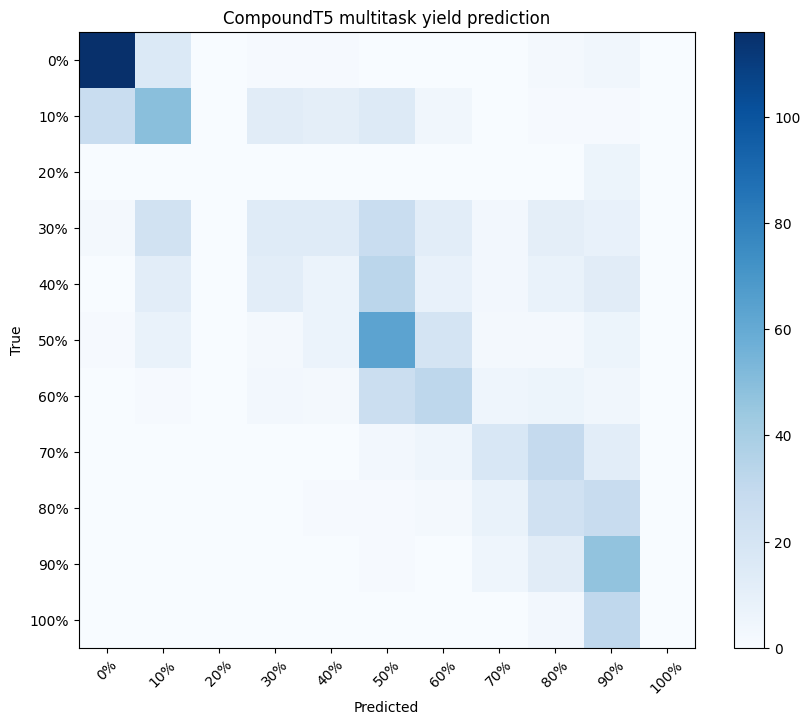

In [42]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Define the labels
labels = ['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%']

# Create the confusion matrix
cm = confusion_matrix(df['target'], df['0th'])

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('CompoundT5 multitask yield prediction')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()